In [6]:
from datetime import datetime
from src.ScoreModels import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pickle

## Models implemented

I built 5 data pipelines with different models:  
1. Random forest (RF)
2. XGBoost (XGB)
3. LightGBM (LGBM)
4. Linear: ElasticNet
5. K Nearest Neighbors (KNN)

In [7]:
# load kwargs from ./params/*.json
kwargs_RF = json.load(open('./params/RF.json', 'r'))
kwargs_XGB = json.load(open('./params/XGB.json', 'r'))
kwargs_LGBM = json.load(open('./params/LGBM.json', 'r'))
kwargs_Linear = json.load(open('./params/Linear.json', 'r'))
kwargs_KNN = json.load(open('./params/KNN.json', 'r'))

In [8]:
# load trained pipelines from ./output/train/*.pickle
RF = pickle.load(open(
    './output/train/n1K_ScorePipelineRF.pickle',
    'br'
))
XGB = pickle.load(open(
    './output/train/n1K_ScorePipelineXGB.pickle',
    'br'
))
LGBM = pickle.load(open(
    './output/train/n1K_ScorePipelineLGBM.pickle',
    'br'
))
Linear = pickle.load(open(
    './output/train/n1K_ScorePipelineLinear.pickle',
    'br'
))
KNN = pickle.load(open(
    './output/train/n1K_ScorePipelineKNN.pickle',
    'br'
))

## Model pipeline structure design

RF, XGB and LGBM model pipeline share same deisgn as below:

In [38]:
RF.print_design()

0 Load raw data
1 Common data cleaning + feature engineering
2 Prepare corss-validate datasets
3 Fill null values in attendance_rate
4 Model hyper parameter tuning
5 Final model training or prediction


**NOTE**: The strategy to fill null in `attendance_rate` is the population median value with same `sleep_length`. To prevent data leaking, we can only fill them after train / validate datasets split.

KNN model pipeline has extra steps to apply standard scaler to X features:

In [39]:
KNN.print_design()

0 Load raw data
1 Common data cleaning + feature engineering
2 Prepare corss-validate datasets
3 Apply StandardScaler transform to cv datasets
4 Fill null values in attendance_rate
5 Model hyper parameter tuning
6 Apply StandardScaler transform to X data
7 Final model training or prediction


Linear (ElasticNet) model pipeline futher add polynominal feature transformer:  
- Degree of polynominal transformer is tuned as a hyper parameter.

In [40]:
Linear.print_design()

0 Load raw data
1 Common data cleaning + feature engineering
2 Prepare corss-validate datasets
3 Apply StandardScaler transform to cv datasets
4 Fill null values in attendance_rate
5 Model hyper parameter tuning
6 Apply StandardScaler transform to X data
7 Apply polynominal features transform to X data
8 Final model training or prediction


## CV score comparison

**Metric**  
- Root Mean Square Error (RMSE)
$$\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{N}\left\| y(i)-\hat{y}(i) \right\|^2}{N}}$$

**Cross Validation**  
- Default 5 folds

**Hyper parameter tuning**  
- 1000 trials by Optuna.
- Detailed settings please refer to *.json files in './params/'

In [9]:
scores = [
    RF.score['main'], 
    XGB.score['main'], 
    LGBM.score['main'],
    Linear.score['main'],
    KNN.score['main']
]
scores = pd.Series(scores, ['RF', 'XGB', 'LGBM', 'Linear', 'KNN'], 
                   name='rmse cv_score')
scores.to_frame()

,rmse cv_score
RF,5.275177
XGB,5.259733
LGBM,5.321919
Linear,7.962754
KNN,7.642870


Tree based models (RF, XGB, LGBM) show much better performance than linear and KNN models.

## Feature permutation importance

In [10]:
%%capture --no-stderr
# calculate permutation importance
RF_permu = RF.permu_importance(**kwargs_RF)
XGB_permu = XGB.permu_importance(**kwargs_XGB)
LGBM_permu = LGBM.permu_importance(**kwargs_LGBM)
Linear_permu = Linear.permu_importance(**kwargs_Linear)
KNN_permu = KNN.permu_importance(**kwargs_KNN)

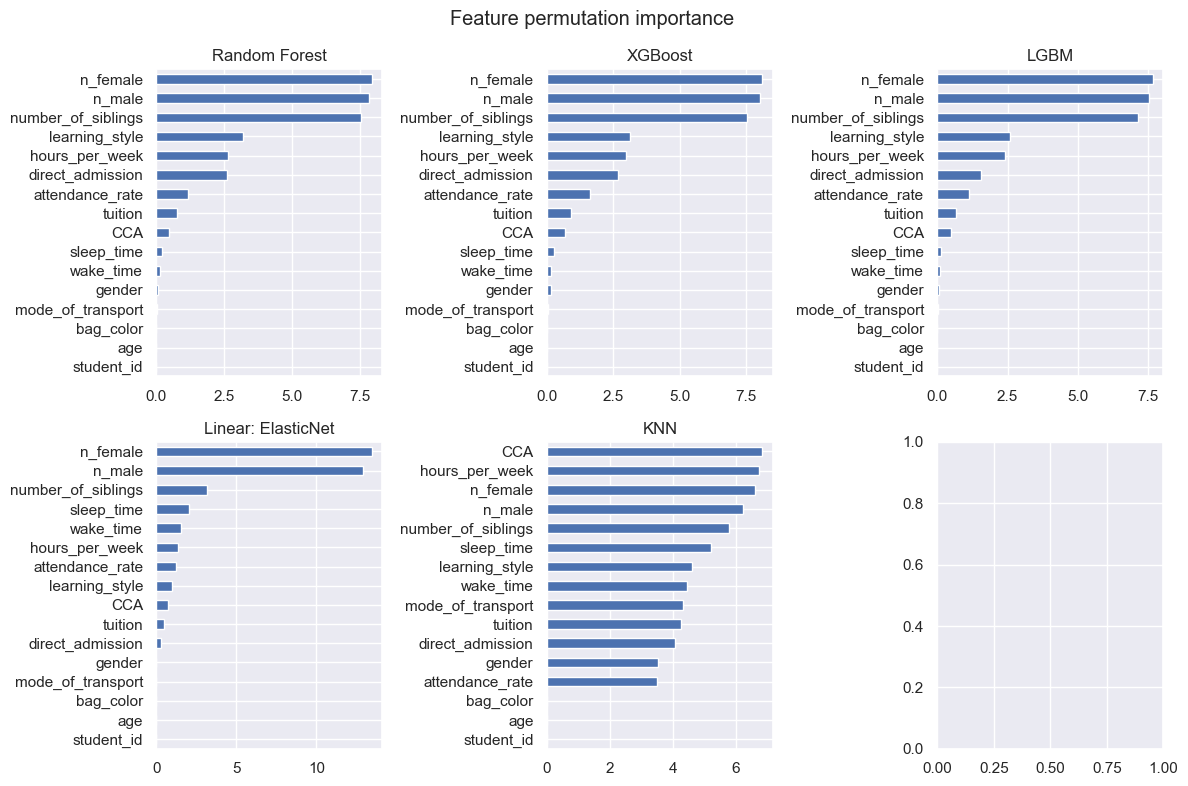

In [11]:
# plot permutation importance
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
RF_permu.plot.barh(ax=axs[0, 0])
XGB_permu.plot.barh(ax=axs[0, 1])
LGBM_permu.plot.barh(ax=axs[0, 2])
Linear_permu.plot.barh(ax=axs[1, 0])
KNN_permu.plot.barh(ax=axs[1, 1])
fig.suptitle('Feature permutation importance')
axs[0, 0].set_title('Random Forest')
axs[0, 1].set_title('XGBoost')
axs[0, 2].set_title('LGBM')
axs[1, 0].set_title('Linear: ElasticNet')
axs[1, 1].set_title('KNN')
fig.tight_layout()
plt.show()

**NOTE**: Above permutation importance calculation is based on raw data features, NOT including engineered features.

**Key highlights**  
- All tree based models (RF, XGB, LGBM) show similar results
    - This is consistent with the fact that their cv scores are also comparable, indicating they all model the data in similar way.
    - `n_female` and `n_male` are the most important features. This is consistent with our EDA findings that `class_size` and `male_ratio` have high prediction power. The root cause is the ratio of talented (direct admission) male students are assigned to bigger and/or female dominant classes.
- Linear model's 3rd important feature is also `number_of_siblings`, though the abosolute importance value is much lower than tree models.
    - Based on EDA we know `number_of_siblings` has strong prediction power, but the correlation to `final_test` is NOT linear. That explains why linear model underestimate its importance.
- KNN model basically cannot tell the importance of all features.
    - To build successful KNN model, you have to tell the model the importance of all features by scaling. This is one of the main disadvantages of KNN model.
        - Another disadvantage is prediction takes long time especially when the training dataset is big.
    - In my KNN model pipeline, standard scaler is applied to all features. Basically this scaler puts all features in the same scale (importance), so the above permutation importance result is not surprising.
        - `student_id`, `age` and `bag_color` were dropped from X features for all models (due to EDA disproves their prediction power), so of course their permutation importances are all zero.

## Feature importance by model

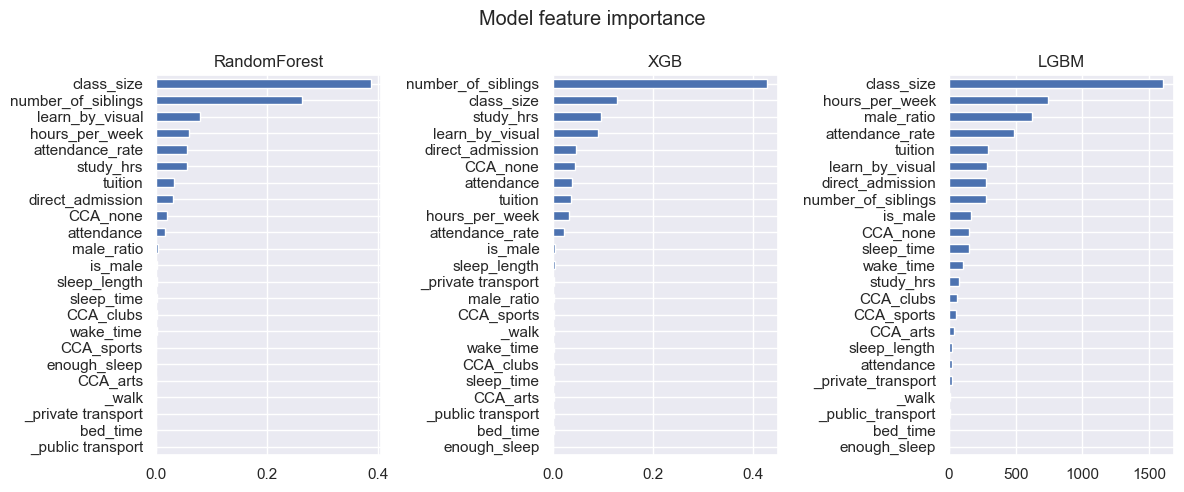

In [37]:
# get model feature importance
RF_model = RF.__pipe_registry__[('main', '5')]['estimator']
RF_importance = pd.Series(
    RF_model.feature_importances_,
    index=RF_model.feature_names_in_,
    name='RF'
).sort_values()
XGB_model = XGB.__pipe_registry__[('main', '5')]['estimator']
XGB_importance = pd.Series(
    XGB_model.feature_importances_,
    index=XGB_model.feature_names_in_,
    name='XGB'
).sort_values()
LGBM_model = LGBM.__pipe_registry__[('main', '5')]['estimator']
LGBM_importance = pd.Series(
    LGBM_model.feature_importances_,
    index=LGBM_model.feature_name_,
    name='LGBM'
).sort_values()

# plot model feature importance
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
RF_importance.plot.barh(ax=axs[0])
XGB_importance.plot.barh(ax=axs[1])
LGBM_importance.plot.barh(ax=axs[2])
axs[0].set_title('RandomForest')
axs[1].set_title('XGB')
axs[2].set_title('LGBM')
fig.suptitle('Model feature importance')
fig.tight_layout()
plt.show()

- RF, XGB and LGBM models all have native class attibutes of feature importance, though their algorithms are not same so the results are not the same.
    - Only final engineered features are shown.
- Roughly speaking they are still consistent with previous permutation importance.
- For fair comparison between all models, I think permuatation importance is more suitable.

## Optuna tuning score trend comparison

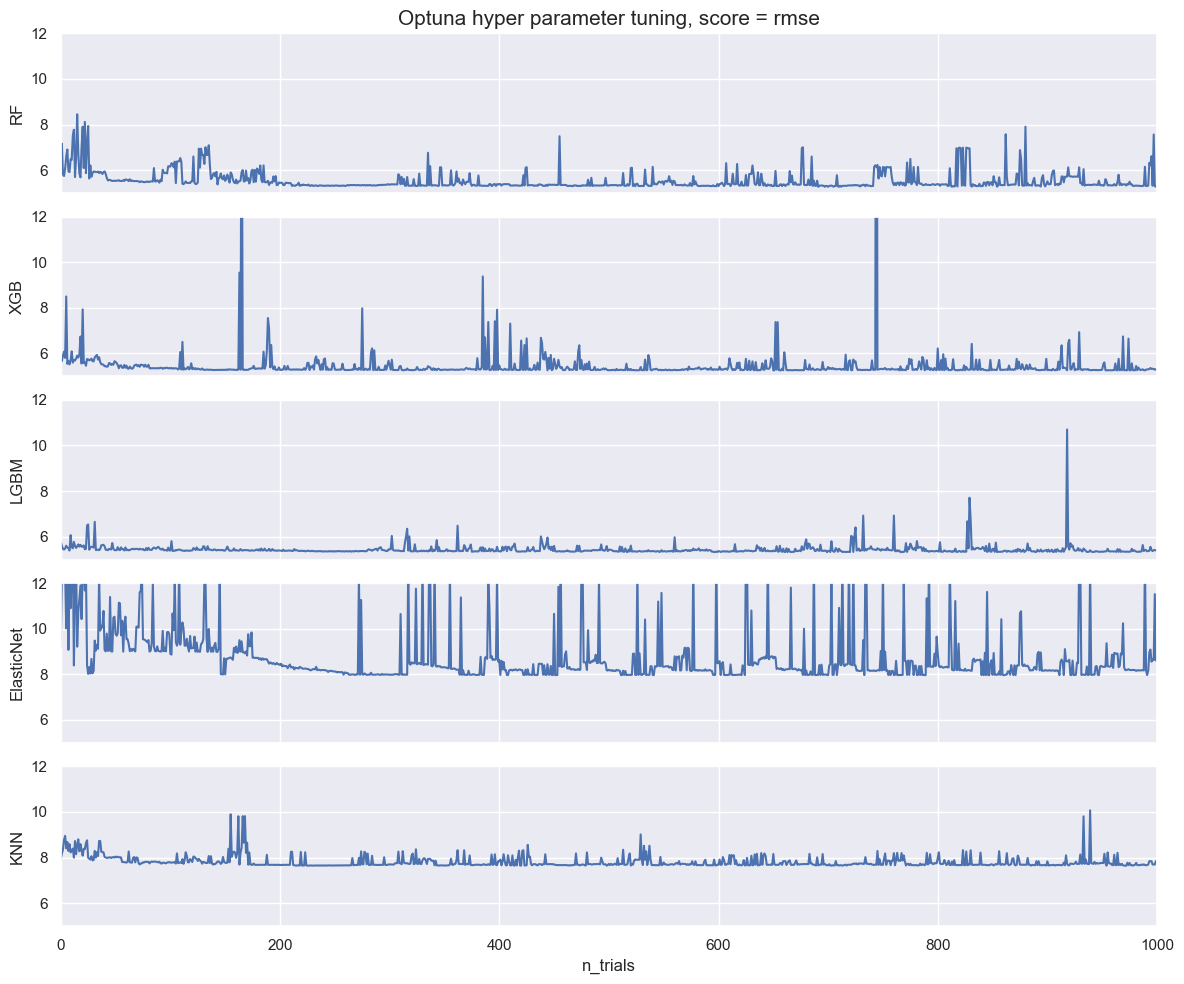

In [22]:
# load Optuna study records
RF_study = RF.__pipe_registry__[('main', '4')]['study']
XGB_study = XGB.__pipe_registry__[('main', '4')]['study']
LGBM_study = LGBM.__pipe_registry__[('main', '4')]['study']
Linear_study = Linear.__pipe_registry__[('main', '5')]['study']
KNN_study = KNN.__pipe_registry__[('main', '5')]['study']

# plot Optuna tuning score trend
fig, axs = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(12, 10))
RF_tune = [x.values[0] for x in RF_study.trials]
sns.lineplot(RF_tune, ax=axs[0])
XGB_tune = [x.values[0] for x in XGB_study.trials]
sns.lineplot(XGB_tune, ax=axs[1])
LGBM_tune = [x.values[0] for x in LGBM_study.trials]
sns.lineplot(LGBM_tune, ax=axs[2])
Linear_tune = [x.values[0] for x in Linear_study.trials]
sns.lineplot(Linear_tune, ax=axs[3])
KNN_tune = [x.values[0] for x in KNN_study.trials]
sns.lineplot(KNN_tune, ax=axs[4])
plt.xlim(0, 1000)
plt.ylim(5, 12)
axs[0].set_ylabel('RF')
axs[1].set_ylabel('XGB')
axs[2].set_ylabel('LGBM')
axs[3].set_ylabel('ElasticNet')
axs[4].set_ylabel('KNN')
axs[4].set_xlabel('n_trials')
axs[0].set_title('Optuna hyper parameter tuning, score = rmse', fontsize = 15)
fig.tight_layout()
plt.show()

Compare all tree based models (RF, XGB, LGBM), obviously LGBM model cv score is more consistent and less spike.  
- LGBM model is **less sensitive** to hyper parameters compare to RF and XGB, which I think is a big advantage.